#### Story Generator -> 
#####     Character Generator (Public for all prompts to the image generator) (Done)
#####      Story generation as Scenes with all characters (Done)
#####      Title of the Book Generator (done )
#####       Create a Graph workflow (done)
#####       Dynamic Story and Scenes Creation

To Do:

create a reproducilble chain for creating a image of a scene
research for TTS models
os.env
edit the return
problems:
character inconsistency
style of image changing
Not enough context to bring the whole picture into the book

In [ ]:
import uuid

from typing import TypedDict,List , NotRequired
from langgraph.graph import END,StateGraph
from langchain_core.prompts import PromptTemplate
from storygenerator.schemas import Story,Scenes
from storygenerator.chains import scenesCreationChain,storyCreationChain,usersPromptGradingChain
from storygenerator.imagegenerator import generateImage

## State of the Graph
class BookState(TypedDict):
    users_prompt : str
    story: NotRequired[Story]
    scenes: NotRequired[Scenes]
    grade: NotRequired[str]
    users_id : NotRequired[int]
    
##templates
titleImageGenerationTemplate = PromptTemplate.from_template("""
    create a cover page with image for the title - '{title}' 
    and the one line of the story book is - {oneline}     
                                                                                                             
    make sure:
    -To place this title : '{title}' **ALWAYS INCLUDE THIS TITLE IN THE IMAGE** 
    -Make Sure Texts you create in the image is accurate and not a gibberish so focus more on that
    -Dont Explicitly name things like 'Title of the book' near the title 
""") 

sceneImageGenerationTemplate = PromptTemplate.from_template("""
style_of_the_image : {style}
                                                            
{current_scene}
                                                            
system_message: 
You are a creative AI director who is best at setting the scene from imagination to image.
create the scene mentioned , you will have a context of what happened before and what is the current scene 
- please capture the context of the previous scenes in the current scene if nessasary. 
- Make sure to get scene right with continuity from the characters , previous scenes
- also make sure to generate the image in the {style} style.
                                                            
These are the Characters in the Story:
{character_description}

            
Previous Scenes:
{previous_scenes}                  

""")

## Nodes
def usersPrompt(state:BookState) -> BookState:
    print("Accessing User's prompt...")
    grade = usersPromptGradingChain.invoke({"users_prompt":state["users_prompt"]})
    state["grade"] = grade.isStory.strip().lower()
    return state

def gradeThePrompt(state):
    print("Analysing the User's Prompt...")
    if (state["grade"]=="no"):
        print("Ending the Graph... , User's request is Not Valid")
        return END
    else:
        return "storycreator"
    
def storyCreator(state:BookState) -> BookState:
    print("Entering Story Creation Node...")
    story = storyCreationChain.invoke({"users_prompt":state["users_prompt"]})
    print("Story Created+++")
    
    #### DEBUG
    print("*"*20)
    print("TITLE:",story.title)
    print("CHARACTERS:",story.characterDescription)
    print("STORY:",story.story)
    print("STYLE:",story.style)
    print("ONELINE:",story.oneline)
    print("NUM_OF_SCENES:",story.num_of_scenes)
    print("*"*20)
    #### DEBUG

    state["story"] = story
    state["users_id"] = uuid.uuid4()
    return state

def titleImageCreator(state:BookState) -> BookState:
    print("Entering Title Image Creation Node...")
    story = state["story"]
    prompt = titleImageGenerationTemplate.format(**{"oneline":story.oneline,"character_description":story.characterDescription,"story":story.story,"title":story.title})
    print(prompt)
    generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename="title.png")
    print("Created a Title Image+++")
    return {}

def scenesCreator(state:BookState) -> BookState:
    print("Entering Scenes Creation Node...")
    story = state["story"]
    scenes = scenesCreationChain.invoke({"story":story.story,"character_description":story.characterDescription,"title":story.title,"n":story.num_of_scenes})
    print("Created Scenes+++")

    #### DEBUG
    print("*"*20)
    print("SCENES:")
    for i,scene in enumerate(scenes.scenes):
        print(i,scene)
    print("VOICEOVERS:")
    for i,scene in enumerate(scenes.voiceovers):
        print(i,scene)
    print("*"*20)
    #### DEBUG

    state["scenes"] = scenes
    print(scenes)
    return state

def scenesImageCreator(state:BookState) -> BookState:
    print("Entering Scenes Image Creation Node...")
    story = state["story"]

    for i in range(story.num_of_scenes):
        print(f"Creating Scene{i+1} Image...")
        previous_scenes = "\n".join(state["scenes"].scenes[:i])
        current_scene = state["scenes"].scenes[i]
        kwargs = {"previous_scenes":previous_scenes,"style":story.style,"character_description":story.characterDescription,"story":story.story,"title":story.title,"current_scene":current_scene}
        prompt = sceneImageGenerationTemplate.format(**kwargs)
        print(prompt)
        generateImage(prompt=prompt,filepath=f"stories/{state["users_id"]}",filename=f"scene{i+1}.png")
        print(f"created Scene{i+1} image+++")
    return {}

graph = StateGraph(BookState)

graph.add_node("usersprompt",usersPrompt)
graph.add_node("storycreator",storyCreator)
graph.add_node("titleimagecreator",titleImageCreator)
graph.add_node("scenescreator",scenesCreator)
graph.add_node("scenesimagecreator",scenesImageCreator)

graph.set_entry_point("usersprompt")
graph.add_conditional_edges("usersprompt",gradeThePrompt,[END,"storycreator"])
graph.add_edge("storycreator","titleimagecreator")
graph.add_edge("titleimagecreator",END)
graph.add_edge("storycreator","scenescreator")
graph.add_edge("scenescreator","scenesimagecreator")
graph.add_edge("scenesimagecreator",END)

app = graph.compile()



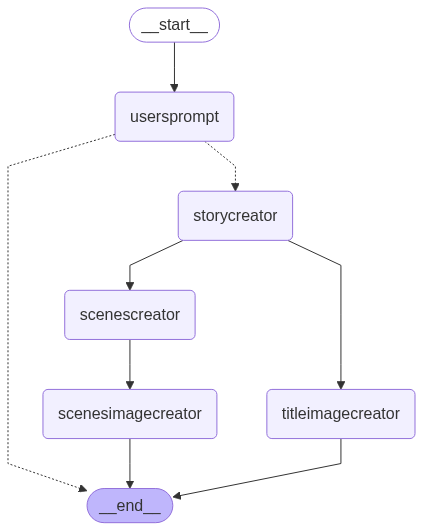

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [21]:
book = app.invoke({"users_prompt":"Create a Story Depicting FriendShip , Love and Hatred "})

Accessing User's prompt...
Analysing the User's Prompt...
Entering Story Creation Node...
Story Created+++
********************
TITLE: Entwined Fates
CHARACTERS: Character 1: Lyra, a 20-year-old free-spirited artist with a passion for music and a kind heart. She has short, spiky hair and piercing green eyes. 
Character 2: Kaid, a 22-year-old brooding musician with a troubled past and a penchant for darkness. He has messy black hair and piercing blue eyes. 
Character 3: Aria, a 21-year-old bubbly fashionista with a flair for drama and a hidden vulnerable side. She has long, curly blonde hair and bright brown eyes.
STORY: In the vibrant city of Luminaria, Lyra, Kaid, and Aria's lives intertwined in a complex dance of friendship, love, and hatred. Lyra, a struggling artist, met Kaid, a talented musician, at an underground music club. They bonded over their passion for music, and Lyra introduced Kaid to her best friend, Aria. The three formed an inseparable trio, with Lyra as the glue that

TypeError: 'Scenes' object is not subscriptable

In [8]:
book["story"].story


"In the bustling city of New York, three individuals from different walks of life found themselves entwined in a complex web of friendship, love, and hatred. Alex, a struggling artist, met Maya, a feisty journalist, at a local art exhibition. Their instant connection led to a deep and abiding friendship. As they explored the city together, they stumbled upon Ethan, a cunning businessman, who had a reputation for crushing his opponents. Maya, intrigued by Ethan's enigmatic persona, began to investigate his shady dealings, which sparked a cat-and-mouse game between them. Meanwhile, Alex found himself drawn to Maya, but their relationship was put to the test when Ethan made a bid to acquire Alex's art studio. As the stakes grew higher, the trio found themselves trapped in a cycle of love, hatred, and deception. Maya's journalistic instincts led her to uncover a dark secret from Ethan's past, which threatened to destroy his empire. Ethan, cornered and desperate, orchestrated a cruel plan t

In [9]:
for i,scene in enumerate(book["scenes"].scenes):
    print(i,scene)
    

0 Scene 1: Alex's art studio, filled with vibrant colors and half-finished paintings, where Alex and Maya first met.
1 Scene 2: A trendy coffee shop in the heart of New York City, where Maya and Alex bonded over their shared passion for art and truth.
2 Scene 3: Ethan's sleek, high-rise office, where he plotted his next move to crush his opponents.
3 Scene 4: A dark alleyway, where Maya confronted Ethan about his shady dealings.
4 Scene 5: Alex's art studio, where Ethan made a bid to acquire the studio, sparking a heated argument between Alex and Maya.
5 Scene 6: A dimly lit, underground nightclub, where Maya discovered a dark secret from Ethan's past.
6 Scene 7: Alex's art studio, where Alex confessed his feelings to Maya, and they shared a romantic moment.
7 Scene 8: Ethan's high-rise office, where he orchestrated a cruel plan to discredit Maya and destroy Alex's art studio.
8 Scene 9: A crowded street in New York City, where Maya and Alex joined forces to expose Ethan's true nature.

In [10]:
for i,scene in enumerate(book["scenes"].voiceovers):
    print(i,scene)

0 Voiceover 1: In a city of millions, three strangers found themselves entwined in a complex web of friendship, love, and hatred.
1 Voiceover 2: Maya's journalistic instincts led her to investigate Ethan's shady dealings, sparking a cat-and-mouse game between them.
2 Voiceover 3: Ethan's ruthless ambition knew no bounds, and he would stop at nothing to get what he wanted.
3 Voiceover 4: Maya's determination to uncover the truth put her in grave danger, but she refused to back down.
4 Voiceover 5: Alex's art studio was more than just a place to create – it was his sanctuary, and he would fight to protect it.
5 Voiceover 6: Maya's discovery of Ethan's dark secret threatened to destroy his empire, and he would do anything to keep it hidden.
6 Voiceover 7: Alex's feelings for Maya went beyond friendship, but could their love survive the chaos that surrounded them?
7 Voiceover 8: Ethan's sinister plot was set in motion, and Maya and Alex found themselves in a desperate fight for survival.
8

In [10]:
print(book["story"].characterDescription)

 Character 1: Ava, a bright and cheerful 20-year-old with curly brown hair and a warm smile, who values friendship above all. 
 Character 2: Ethan, a brooding and intense 22-year-old with chiseled features and piercing blue eyes, who has a dark past and struggles with trust. 
 Character 3: Lily, a sweet and gentle 21-year-old with long blonde hair and a kind heart, who is Ava's best friend and confidant. 
 Character 4: Jackson, a charming and arrogant 23-year-old with a strong jawline and a quick wit, who is Ethan's rival and nemesis.


In [17]:
book["scenes"].scenes[:0]

[]

In [18]:
"\n".join([])

''

In [47]:
from together import Together

client = Together()
response = client.images.generate(
    prompt="Cats eating popcorn",
    model="black-forest-labs/FLUX.1-schnell-free",
    steps=4,
    n=4,
    width=352,   # multiple of 16
    height=256,
    response_format="b64_json"
)
print(response.data[0].b64_json)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAEAAWADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDy8DFOxSCnCtDjAU7FIKdQACnYpBThQIAKdigUtAgFLiilFMQopaSlFACilopRQIWiiloAAKWiigQYpaKWgBMUtLRQISilooATFFLRQAlJS0lAxKSnUlACU2nUlAxtIadSUANNIacaQ0DGUlONJQMbimmnGkNIBtNNOpKBjTTS

In [48]:
import base64
from PIL import Image
from io import BytesIO
# Decode the base64 string to bytes
image_bytes = base64.b64decode(response.data[0].b64_json)

# Open the image using PIL
image = Image.open(BytesIO(image_bytes))

# Optional: Save the image locally
image.save("output_image.png")

# Optional: Show the image
image.show()
